In [3]:
import sinabs
import torch
import torch.nn as nn
import torchvision
import tonic

In [ ]:
class PupilTracking(nn.Module):
    def __init__(self):
        super().__init__()
        self.seq = nn.Sequential(
            # 2 x 128 x 128
            # Core 0
            nn.Conv2d(2, 8, kernel_size=(2, 2), stride=(2, 2), padding=(0, 0), bias=False),  # 8, 64, 64
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=(2, 2)),  # 8,32,32
            # """Core 1"""
            nn.Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),  # 16, 32, 32
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=(2, 2)),  # 16, 16, 16
            # """Core 2"""
            nn.Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),  # 8, 16, 16
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=(2, 2)),  # 16, 16, 16
            nn.Flatten(),
            nn.Linear(8 * 4, 10, bias=False),
            nn.ReLU(),
        )
    def forward(self, x):
        return self.seq(x)


In [ ]:
Net = PupilTracking().to("cuda")


In [ ]:
from torchsummary import summary

input_shape = (2, 34, 34)

summary(Net, input_shape)

In [ ]:
from aermanager.datasets import SpikeTrainDataset
import numpy as np
nmnist_spike_dataset = SpikeTrainDataset(
    '/home/jyz/ssd/snn/data/N-MNIST/Train',
    transform=np.float32, 
    target_transform=int,
    dt=1000)

In [ ]:
events, label = nmnist_spike_dataset[0]
label

In [ ]:
from torch.utils.data import DataLoader
from tonic import DiskCachedDataset


# cached_trainset = DiskCachedDataset(nmnist_spike_dataset, cache_path='./cache/nmnist/train')
batch_size = 64
trainloader = DataLoader(nmnist_spike_dataset, batch_size=batch_size, collate_fn=tonic.collation.PadTensors())

In [ ]:
ann = nn.Sequential(
    nn.Linear(34, 128),
    nn.ReLU(),
    nn.Linear(128, 128),
    nn.ReLU(),
    nn.Linear(128, 256),
    nn.ReLU(),
    nn.Linear(256, 256),
    nn.ReLU(),
    nn.Linear(256, 10),
    nn.ReLU(),
)

In [ ]:
from sinabs.from_torch import from_model

BATCH_SIZE = 32
model = from_model(Net, input_shape=input_shape).to("cuda")

In [ ]:
model.spiking_model

In [ ]:
for img in trainloader:
    print(img[0].shape)
    break

In [ ]:
img[0].size(0)

In [4]:
import snntorch as snn
from snntorch import surrogate
from snntorch import functional as SF
from snntorch import spikeplot as splt
from snntorch import utils

In [5]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# neuron and simulation parameters
spike_grad = surrogate.fast_sigmoid(slope=75)
beta = 0.5

#  Initialize Network
net = nn.Sequential(nn.Conv2d(2, 12, 5),
                    nn.MaxPool2d(2),
                    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True),
                    nn.Conv2d(12, 32, 5),
                    nn.MaxPool2d(2),
                    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True),
                    nn.Flatten(),
                    nn.Linear(32*5*5, 10),
                    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True, output=True)
                    ).to(device)

In [6]:
def forward_pass(net, data):
    spk_rec = []
    if isinstance(net, nn.Sequential):
        utils.reset(net)
        for step in range(data.size(0)):
            spk_out, mem_out = net(data[step])
            spk_rec.append(spk_out)
    else:
        net.reset_states()
        for step in range(data.size(0)):
            spk_out = net(data[step])
            spk_rec.append(spk_out)
    
    return torch.stack(spk_rec)


In [7]:
import tonic.transforms as transforms

sensor_size = tonic.datasets.NMNIST.sensor_size

# Denoise removes isolated, one-off events
# time_window
frame_transform = transforms.Compose([transforms.Denoise(filter_time=10000),
                                      transforms.ToFrame(sensor_size=sensor_size,
                                                         time_window=1000)
                                     ])

trainset = tonic.datasets.NMNIST(save_to='./data2', transform=frame_transform, train=True)

In [ ]:
img, label = trainset[0]
label

In [8]:
from torch.utils.data import DataLoader
from tonic import DiskCachedDataset

transform = tonic.transforms.Compose([torch.from_numpy,
                                      torchvision.transforms.RandomRotation([-10,10])])

cached_trainset = DiskCachedDataset(trainset, transform=transform, target_transform=int , cache_path='./cache/nmnist/train')

# no augmentations for the testset
# cached_testset = CachedDataset(testset, cache_path='./cache/nmnist/test')

batch_size = 32
trainloader = DataLoader(cached_trainset, batch_size=batch_size, collate_fn=tonic.collation.PadTensors(), shuffle=True)
# testloader = DataLoader(cached_testset, batch_size=batch_size, collate_fn=tonic.collation.PadTensors())

In [ ]:
img, label = cached_trainset[0]
label

In [9]:
optimizer = torch.optim.Adam(net.parameters(), lr=2e-2, betas=(0.9, 0.999))
# loss_fn = nn.CrossEntropyLoss()
loss_fn = SF.mse_count_loss(correct_rate=0.8, incorrect_rate=0.2)

In [10]:
num_epochs = 1
num_iters = 100

loss_hist = []
acc_hist = []

# training loop
for epoch in range(num_epochs):
    for i, (data, targets) in enumerate(iter(trainloader)):
        data = data.to(device)
        targets = targets.to(device)

        net.train()
        spk_rec = forward_pass(net, data)
        loss_val = loss_fn(spk_rec, targets)
        # loss_val = loss_val / spk_rec.size(0)
        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # Store loss history for future plotting
        loss_hist.append(loss_val.item())

        print(f"Epoch {epoch}, Iteration {i} \nTrain Loss: {loss_val.item():.2f}")

        acc = SF.accuracy_rate(spk_rec, targets)
        acc_hist.append(acc)
        print(f"Accuracy: {acc * 100:.2f}%\n")

        # training loop breaks after 50 iterations
        if i == num_iters:
          break

Epoch 0, Iteration 0 
Train Loss: 31.00
Accuracy: 9.38%

Epoch 0, Iteration 1 
Train Loss: 30.90
Accuracy: 6.25%

Epoch 0, Iteration 2 
Train Loss: 30.58
Accuracy: 6.25%

Epoch 0, Iteration 3 
Train Loss: 30.96
Accuracy: 21.88%

Epoch 0, Iteration 4 
Train Loss: 30.58
Accuracy: 15.62%

Epoch 0, Iteration 5 
Train Loss: 30.96
Accuracy: 9.38%

Epoch 0, Iteration 6 
Train Loss: 30.46
Accuracy: 9.38%

Epoch 0, Iteration 7 
Train Loss: 30.46
Accuracy: 15.62%

Epoch 0, Iteration 8 
Train Loss: 30.52
Accuracy: 9.38%

Epoch 0, Iteration 9 
Train Loss: 30.52
Accuracy: 6.25%

Epoch 0, Iteration 10 
Train Loss: 30.52
Accuracy: 9.38%

Epoch 0, Iteration 11 
Train Loss: 31.00
Accuracy: 15.62%

Epoch 0, Iteration 12 
Train Loss: 30.90
Accuracy: 15.62%

Epoch 0, Iteration 13 
Train Loss: 30.19
Accuracy: 12.50%

Epoch 0, Iteration 14 
Train Loss: 20.93
Accuracy: 6.25%

Epoch 0, Iteration 15 
Train Loss: 12.84
Accuracy: 6.25%

Epoch 0, Iteration 16 
Train Loss: 17.91
Accuracy: 15.62%

Epoch 0, Iteratio

In [ ]:
data.shape


In [ ]:
spk_rec.shape

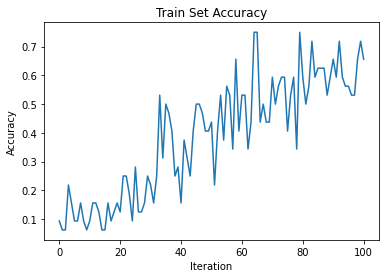

In [11]:
import matplotlib.pyplot as plt

# Plot Loss
fig = plt.figure(facecolor="w")
plt.plot(acc_hist)
plt.title("Train Set Accuracy")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.show()